### 迭代梯度下降法
1. 1-2中介绍了整体梯度下降法，但是这个对于大量的学习样本，效率是比较低的，因为每次迭代都要将所有样本全部参与计算，并且容易陷入到局部最优解中。因此书中提出了**迭代梯度下降法**(又称为随机梯度下降法)，与1-2中的整体梯度下降法中权重更新不同的是，对于整体梯度下降法有：
$$
w := w + \eta \sum_{i}(y^{(i)}-\phi (z^{(i)})x^{(i)}_j 
$$
对于迭代梯度下降法，通常每次只是使用一个样本来更新权重：
$$
w := w + \eta(y^{(i)}-\phi (z^{(i)})x^{(i)}_j 
$$
这样，对于在线学习，即可采用流的方式每次更新一次权重，这样也容易跳出局部最优解。

2. 细节
    1. 书中还提到了shuffle，翻译过来是重新洗牌的意思，也就是在迭代梯度下降法时，每迭代一次，就将数据打乱，这样也容易跳出局部最优解。

In [9]:
import numpy as np
from numpy import random

class GradientDescent:
    
    def __init__(self, learn_rate, iter_nums):
        """
            构造函数，初始化梯度下降参数
            parameters:
            learn_rate: float, 学习速率
            iter_nums： int,   迭代次数，对于在线学习无效
            
            return: self
        
        """
        self.learn_rate = learn_rate
        self.iter_nums = iter_nums
        self.wight = None
        self.costs = []
        self.__is_init_wight = False
    
    def fit(self, X, Y):
        """
            parameters:
            X: np.ndarray, size:[simples,features]
            Y：np.ndarray, size:features
            
            return: self
        """
        simples,features = X.shape
        self.__init_wight(features+1)
        
        # 经过测试，对于numpy的一维向量，numpy会自动进行广播（brodacast）扩展维度，不需要考虑维度
        # Y = Y.reshape((simples, 1))
        
        for _ in range(self.iter_nums):
            # shuffle
            X, Y = self.__shuffle(X, Y)
            cost = 0
            for x,y in zip(X,Y):
                cost += self.__partial_update_wight(x,y)
            # average cost
            self.costs.append(cost / len(Y))
        
        return self
    
    def __init_wight(self, rows, cols = 1): 
        self.wight = np.random.random(rows)
        # self.wight = np.zeros(rows)
    
    
    def __shuffle(self, X, Y):
        index = np.random.permutation(len(Y))
        return (X[index], Y[index])
    
    def partial_fit(self, X, Y):
        """
            小批次训练，可以每次只训练一个样本集，也可以训练多个样本集。
            parameters:
            X: np.ndarray, size:[simples,features] or a vector that its length is count of features.
            Y：np.ndarray, size:features
            
            return: self
        """
        features = len(X) if X.ndim == 1 else X.shape[1]
        if not self.__is_init_wight:
            self.__is_init_wight = True
            self.__init_wight(features + 1)
        
        # 经过测试，对于numpy的一维向量，只管计算即可，不需要管维度
        # Y = Y.reshape((simples, 1))
        
        # 多个样本集的情况
        if X.ndim > 1:
            cost = 0
            for x,y in zip(X,Y):
                cost += self.__partial_update_wight(x, y)
            self.costs.append(cost / len(Y))
        else:
            cost = self.__partial_update_wight(X, Y)
            self.costs.append(cost)
            
        return self
    
    
    def __partial_update_wight(self, X, Y):
        """
        单个样本集训练
        parameters:
            X: np.ndarray, 特征值，a vector that its length is count of features.
            Y：np.ndarray, 实际值，a vector that its length is count of features.
            
            return: cost
        """
        predict = self.net_input(X)
        _error = Y - predict
        self.wight[1:] += self.learn_rate * np.dot(X, _error)
        self.wight[0]  += self.learn_rate * _error
        # cost
        return _error ** 2 * 0.5
        
        
    def net_input(self, x):
        """
            parameters:
            x: np.ndarray, size:[simples,features]

            return: np.ndarray, size:[simples,1]
        """
        
        return self.wight[0] + np.dot(x, self.wight[1:,])
    
    def predict(self, x):
        """
            parameters:
            x: n.ndarray, size:[simples,features]
            
            return: np.ndarray, size:[simples,1]
        """
        return np.where(self.net_input(x) > 0, 1, -1)

### 数据读取、处理
对数据进行特征缩放，即数据标准化，对第$j$个特征的一系列值进行标准化处理，公式为：
$$
x_j^{'}=\frac{x_j-u_j}{\sigma_j}
$$

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

Y = df.iloc[0:100,4].values
Y = np.where(Y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100,[0,2]].values

# 对数据进行标准化
X[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:,0].std()
X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:,1].std()

### 批量梯度训练模型

In [40]:
gd = GradientDescent(0.01, 15)
gd.fit(X, Y)

### 绘制损耗函数

NameError: name 'gd' is not defined

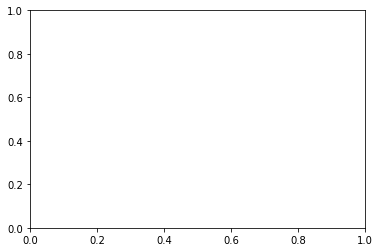

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
ax = plt.axes()
ax.plot(gd.costs)

可以从上图看到，当学习速率为0.01时，误差平方和不断减小，说明不断逼近最优解，且相比于整体梯度下降法，效果要更好。  
我们绘制出训练结果：

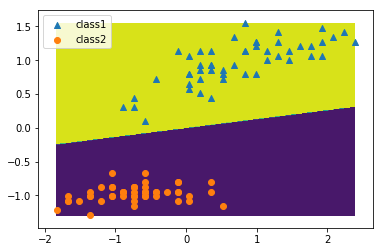

In [63]:
# 构建源数据
interval = 0.01
x0_min, x0_max = X[:, 0].min(),X[:, 0].max()
x1_min, x1_max = X[:, 1].min(),X[:, 1].max()

xy, yx = np.meshgrid(np.arange(x0_min, x0_max, interval),
                    np.arange(x1_min, x1_max,interval))

z = np.array([xy.ravel(), yx.ravel()]).T

# 预测
z_predict = []
for _z in z:
    z_predict.append(gd.predict(_z))
    
z_predict = np.array(z_predict).reshape(xy.shape)
# 绘制结果
ax = plt.axes()
ax.contourf(xy, yx, z_predict)
# 绘制原始数据
ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='^', label='class1')
ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', label='class2')
ax.legend()

### 接下来我们模拟在线机器学习

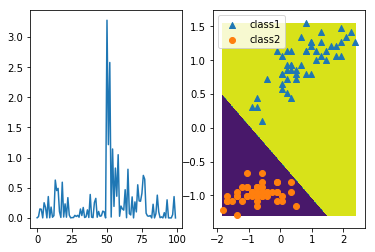

In [20]:
# 每次训练一个样本集,因此与迭代参数无关
gd2 = GradientDescent(0.01, 12)
for x,y in zip(X,Y):
    gd2.partial_fit(x,y)
    
# 绘制代价函数
%matplotlib inline
fig,ax = plt.subplots(1,2)
ax[0].plot(gd2.costs)


# 绘制训练结果
interval = 0.01
x0_min, x0_max = X[:, 0].min(),X[:, 0].max()
x1_min, x1_max = X[:, 1].min(),X[:, 1].max()

xy, yx = np.meshgrid(np.arange(x0_min, x0_max, interval),
                    np.arange(x1_min, x1_max,interval))

z = np.array([xy.ravel(), yx.ravel()]).T

# 预测
z_predict = []
for _z in z:
    z_predict.append(gd2.predict(_z))
    
z_predict = np.array(z_predict).reshape(xy.shape)
# 绘制结果
ax[1].contourf(xy, yx, z_predict)
# 绘制原始数据
ax[1].scatter(X[Y == 1,0], X[Y == 1,1], marker='^', label='class1')
ax[1].scatter(X[Y == -1,0], X[Y == -1,1], marker='o', label='class2')
ax[1].legend()

经过多次运行发现效果极其不稳定，经常会出现欠拟合的情况。经过我的测试，可以将48行代码注释掉，取消49行代码注释，发现与权重的初始值有着很大关系，并且从左图可以看出在训练过程中多次达到局部最优解，可是损耗函数又突然骤增。